# **Part II : Statistical Analysis**


In this section, we will conduct various statistical hypothesis tests, apply estimation statistics, and interpret the results to validate the findings from part one. We will use both parametric and non-parametric tests and report all significant insights. This part requires a strong statistical background, and we will use our knowledge to delve deeper into the data.

I perform the following steps:

    Preprocess the data, following the same steps as in Part 1 of the EDA.
    Test for independence between pairs of categorical attributes.
    Test for normality of the distribution of each numeric attribute.
    Analyze the correlation between pairs of numeric attributes.
    Perform both parametric and non-parametric tests to compare samples.

Throughout the notebook, I make use of hypothesis testing techniques to draw statistical conclusions.

# **About Dataset**

We are working with the city-cycle fuel consumption dataset, which consists of data related to city-cycle fuel consumption in miles per gallon. The dataset includes 398 instances, and there are 8 attributes, including 3 multi-valued discrete and 5 continuous attributes. The goal is to predict the attribute "mpg" using regression.

It's worth noting that the dataset contains missing values, and 8 instances were removed due to unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original". The attribute information shows that one of the attributes is a string type and is unique for each instance, which is the car name attribute.

This is a multivariate dataset with both categorical and real attribute characteristics, and it's associated with a regression task.

**Source**:

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.


**Data Set Information:**

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)


**Attribute Information**:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

In [ ]:
import itertools
import os
import pathlib
import random
import time

import cv2
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools

from glob import glob
from tqdm import tqdm_notebook, tnrange
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from statsmodels.graphics.gofplots import qqplot


# **Data Cleaning**

In [ ]:
df = pd.read_csv('city-cycle fuel consumption dataset.csv')

In [ ]:
df.head(2).transpose()

,0,1
mpg,18.0,15.0
cylinders,8,8
displacement,307.0,350.0
horsepower,130.0,165.0
weight,3504,3693
acceleration,12.0,11.5
model_year,70,70
origin,usa,usa
name,chevrolet chevelle malibu,buick skylark 320


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [ ]:
df.shape

(398, 9)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model_year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


In [ ]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'Number of categorical variables: {len(cats)}')
print(f'Categorical variables: {cats}')
print(f'\nNumber of numerical variables: {len(nums)}')
print(f'Numerical variables: {nums}')

Number of categorical variables: 2
Categorical variables: ['origin', 'name']

Number of numerical variables: 7
Numerical variables: ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']


**Inspect number of unique values in each column**

Given the limited number of unique values for both cylinders and model_year, it is recommended to treat them as categorical variables instead of numeric variables.

In [ ]:
df.nunique(axis=0)

mpg             129
cylinders         5
displacement     82
horsepower       93
weight          351
acceleration     95
model_year       13
origin            3
name            305
dtype: int64

In [ ]:
# add cylinders and model_year to categorical variables
cats += ['cylinders', 'model_year']

# remove cylinders and model_year from numerical variables
nums.remove('cylinders')
nums.remove('model_year')

# print updated lists of variables
print(f'Categorical variables: {cats}')
print(f'Numerical variables: {nums}')


Categorical variables: ['origin', 'name', 'cylinders', 'model_year']
Numerical variables: ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']


In [ ]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

The horsepower feature has only 6 NaN rows, accounting for around 1.5% of the total data. Since this fraction is relatively small, we can safely drop these NaN rows for the time being.

let's see these 6 `nan`

In [ ]:
df[df.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [ ]:
# proportion of nan rows in dataset
6 / len(df)

0.01507537688442211

In [ ]:
#Remove all rows with NaN values
df.dropna(inplace=True)

#Reset index and drop old index column
df.reset_index(drop=True, inplace=True)

#Print new shape of the dataframe
print(f"New shape of the dataframe after removing NaN rows: {df.shape}")

New shape of the dataframe after removing NaN rows: (392, 9)


In [ ]:
# find total duplicate entries and drop them if any
print(f"Total duplicate rows: {df.duplicated().sum()}")

# drop duplicate rows if any
df = df[~df.duplicated()]
df.shape

if df.duplicated().sum() == 0:
    print("No duplicates found. DataFrame is ready for analysis.")
else:
    print("Duplicates removed. DataFrame is ready for analysis.")


Total duplicate rows: 0
No duplicates found. DataFrame is ready for analysis.


In [ ]:
# remove extra spaces if any
for col in ['origin', 'name']:
    df[col] = df[col].str.strip()


In [ ]:
# Create a new feature 'mpg_level' based on the 'mpg' column
df['mpg_level'] = df['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')

# Add 'mpg_level' to the list of categorical variables
cats.append('mpg_level')

# Print the updated list of categorical variables
print(f'Categorical variables: {cats}')


Categorical variables: ['origin', 'name', 'cylinders', 'model_year', 'mpg_level']


In [ ]:
# Combine all categorical and numerical variables into a single dataframe
df = pd.concat((df[cats], df[nums]), axis=1)
df.head(1)


,origin,name,cylinders,model_year,mpg_level,mpg,displacement,horsepower,weight,acceleration
0,usa,chevrolet chevelle malibu,8,70,medium,18.0,307.0,130.0,3504,12.0


# **Section 1. Statistical Analysis for Categorical Attributes**

In [ ]:
ALPHA = 0.05

Although the chi-square assumption failed for every pair, we can still apply it to some extent. However, the results obtained may not be entirely reliable. However, the contingency table of origin and model_year is suitable for testing since most values are greater than or equal to 5.

We can formulate our hypothesis test as follows:

   H0: The origin and model_year are independent.
       α=0.05

In [ ]:
# Create a contingency table (aka frequency table) of origin and model_year
contingency_table = pd.crosstab(df.origin, df.model_year)

# Print the contingency table
print("Contingency Table (Frequency Table) of Origin and Model Year:\n")
contingency_table


Contingency Table (Frequency Table) of Origin and Model Year:



model_year,70,71,72,73,74,75,76,77,78,79,80,81,82
origin,,,,,,,,,,,,,
europe,5,4,5,7,6,6,8,4,6,4,8,3,2
japan,2,4,5,4,6,4,4,6,8,2,13,12,9
usa,22,19,18,29,14,20,22,18,22,23,6,13,19


In [ ]:
# Calculate the observed values for chi-squared test
observed_values = pd.crosstab(df.origin, df.mpg_level).values
print("Observed values:\n", observed_values)


Observed values:
 [[ 22   2  44]
 [ 49   0  30]
 [ 24  90 131]]


In [ ]:
# Compute chi-square test of independence
chi2, p, dof, expected_values = st.chi2_contingency(observed_values)

# Print results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected values:")
print(expected_values.round(2))


Chi-square statistic: 123.76
P-value: 0.0000
Degrees of freedom: 4
Expected values:
[[ 16.48  15.96  35.56]
 [ 19.15  18.54  41.31]
 [ 59.38  57.5  128.12]]


Based on the p-value of 0.000 under the significance level of 0.05, we reject the null hypothesis that `origin` and `model_year` are independent. Therefore, we conclude that there is a statistically significant relationship between these two variables.


In [ ]:
if p <= ALPHA:
    print(f'Based on the p-value of {p:.3f} under the significance level of {ALPHA}, we reject the null hypothesis that `origin` and `model_year` are independent. Therefore, we conclude that there is a statistically significant relationship between these two variables.')
else:
    print(f'Based on the p-value of {p:.3f} under the significance level of {ALPHA}, we fail to reject the null hypothesis that `origin` and `model_year` are independent. Therefore, we do not have enough evidence to conclude that there is a significant relationship between these two variables.')


Based on the p-value of 0.000 under the significance level of 0.05, we reject the null hypothesis that `origin` and `model_year` are independent. Therefore, we conclude that there is a statistically significant relationship between these two variables.


In below we want to use chi2 test available in SkLearn

In [ ]:
# Apply label encoding to origin and mpg_level columns
df_cat_label = df.loc[:, ['origin', 'mpg_level']].apply(LabelEncoder().fit_transform)

# Combine encoded columns with the rest of the categorical columns
df_cat_label = pd.concat([df_cat_label, df.loc[:, 'cylinders':'model_year']], axis=1)

# Display the first few rows of the new dataframe
df_cat_label.head()


,origin,mpg_level,cylinders,model_year
0,2,2,8,70
1,2,1,8,70
2,2,2,8,70
3,2,1,8,70
4,2,2,8,70


In [ ]:
# Perform chi-square test for each categorical feature against mpg_level
chi2_res = feature_selection.chi2(df_cat_label, df.mpg_level)

# Create a dataframe to store the results
df_chi2 = pd.DataFrame({
    'Feature 1': 'mpg_level',
    'Feature 2': df_cat_label.columns,
    'Chi-square': chi2_res[0],
    'p-value': chi2_res[1],
    'Alpha': ALPHA
})

# Determine whether to reject or fail to reject null hypothesis
df_chi2['H0'] = df_chi2['p-value'].apply(lambda x: 'Rejected' if x <= ALPHA else 'Fail to reject')

# Classify features as dependent or independent based on the null hypothesis
df_chi2['Relation'] = df_chi2['H0'].apply(lambda x: 'Dependent' if x == 'Rejected' else 'Independent')

# Display the results
df_chi2


,Feature 1,Feature 2,Chi-square,p-value,Alpha,H0,Relation
0,mpg_level,origin,28.395578,6.823049e-07,0.05,Rejected,Dependent
1,mpg_level,mpg_level,210.159363,2.314591e-46,0.05,Rejected,Dependent
2,mpg_level,cylinders,127.418999,2.144450e-28,0.05,Rejected,Dependent
3,mpg_level,model_year,21.742075,1.900065e-05,0.05,Rejected,Dependent


**Introduction to Statistical Terminology**

**Population**: Refers to the complete set of observations or data that we are interested in studying.

**Sample**: Refers to a subset of the population. By studying the sample, we can draw conclusions or make inferences about the population.

**Parameters**: These are characteristics or properties of the population that we are interested in. For example, if we are studying the height of all people in a country, the mean height of the entire population is a parameter.

**Estimates**: These are values or measures that we calculate from the sample that help us estimate the parameters of the population. For example, the mean height of a sample can be used to estimate the mean height of the population.

**Descriptive Statistics:** Techniques used to summarize or describe the characteristics of the data. These include measures of central tendency (e.g., mean, median, mode) and measures of variability (e.g., range, variance, standard deviation).

**Inferential Statistics:** Techniques used to draw conclusions or make inferences about the population based on the sample data. For example, we can use inferential statistics to estimate the population mean based on the sample mean.

**Parametric Statistics:** Statistical methods where we make assumptions about the distribution of the data. For example, the Gaussian or normal distribution is commonly assumed in parametric statistics.

**Non-Parametric Statistics:** Statistical methods where we do not make any assumptions about the distribution of the data. These methods are also known as distribution-free methods.

**Statistical Hypothesis Tests:** Methods used to evaluate the likelihood of observing a result given an assumption or expectation about the result. Hypothesis tests can be used to determine if a difference between groups is statistically significant.

**Estimation Statistics:** Methods used to quantify the uncertainty of a result using confidence intervals. Confidence intervals provide a range of values within which the true parameter is likely to lie with a certain level of confidence.

**Statistical Hypothesis Tests: An Overview**

Statistical Hypothesis Tests are a powerful tool to help us validate assumptions we make about the data. The process is straightforward: we first assume something about the data, such as two samples having the same mean. We then calculate the likelihood of observing the data assuming this assumption is true. If the likelihood is very low, we reject the assumption, and if it is not, we fail to reject it.

In statistical terms, the assumption is called a Hypothesis, the likelihood we obtain is called a p-value, and the threshold we set is either the level of significance or critical value. The test we use is called a Statistical Hypothesis Test.

If the likelihood we obtain is close to zero, it means that assuming the hypothesis to be true, the probability of observing/occurring the data is very low. In this case, we reject the hypothesis, as there is likely something wrong with our assumption. For instance, if we compare the means of two samples and the resulting p-value is very low, it suggests that assuming the two samples have the same mean, the data we have is unlikely to be generated, and hence, we reject the assumption.

**Hypothesis Testing in Statistics**

In hypothesis testing, there are two types of hypotheses: the null hypothesis, H0, which suggests that no significant difference exists in a given set of observations, and the alternative hypothesis, H1, which suggests that a significant difference does exist.

In general, the null hypothesis and alternative hypothesis are complementary to each other, and the hypothesis testing framework is set up as follows:

makefile

    H0: Variable A and Variable B are independent
    H1: Variable A and Variable B are not independent.

The p-value is the probability of observing data given the assumption in a statistical test, and it is used to assess the statistical significance of any findings. A p-value can be calculated from a test statistic by retrieving the probability from the test statistic's cumulative density function (CDF).

In the context of a statistical test, if the p-value is less than or equal to a significance level, denoted as α (most commonly used as 0.05 in data science and machine learning), then the result is considered significant, and the null hypothesis is rejected. Otherwise, if the p-value is greater than α, the result is not significant, and the null hypothesis cannot be rejected.

Some tests return a test statistic value from a specific data distribution that can be interpreted in the context of critical values. A critical value is a value from the distribution of the test statistic after which point the result is significant and the null hypothesis can be rejected.

It is important to note that the interpretation of p-values and statistical significance requires a thorough understanding of the underlying statistical tests and their assumptions.

**Independence tests for two categorical variables**

**Pearson's Chi-square test**

The Chi-square test is a non-parametric statistical tool designed to analyze group differences when the dependent variable is measured at a nominal or ordinal level. It is commonly used to compare observed data with data we would expect to obtain according to a specific hypothesis.
χ2=∑(O−E)2E

Where,

  O: Observed (the actual count of cases in each cell of the table)

  E: Expected value (calculated below)

   χ2: The cell Chi-square value

  $\large \chi ^{2} = \sum \frac{(O-E)^{2}}{E}$


Assumptions

   1. The test becomes invalid if any of the expected values are below 5

   2. The p-value calculated is not exact but approximate and converges to exact on increasing data (hence, not suitable for small sample sizes)

   3. The number of observations must be at least 20.

If the expected cell counts are small, it is better to use an exact test as the Chi-squared test is no longer a good approximation in such cases. Therefore, we will use Fisher's exact test to overcome this issue.


**Fisher’s exact test**

Fisher’s exact test is a statistical method used to assess the significance of the association between two categorical variables in a contingency table. It is an alternative to the Pearson’s chi-squared test for independence, and is particularly useful when sample sizes are small. Fisher’s exact test is valid for all sample sizes, but is commonly applied when sample sizes are limited. A guideline for using Fisher’s exact test over the chi-squared test is when more than 20% of cells in a contingency table have expected frequencies less than 5.

# **Section 2. Statistical Analysis for Numerical Attributes**

In [ ]:
nums

['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

Based on the distributions generated in Part1, it is evident that acceleration follows a normal distribution, while mpg and weight are right-skewed or possibly log-normal.

The log-normal distribution is characterized by a random variable whose logarithm follows a normal distribution. To determine if mpg and weight follow a log-normal distribution, we will conduct an analysis.

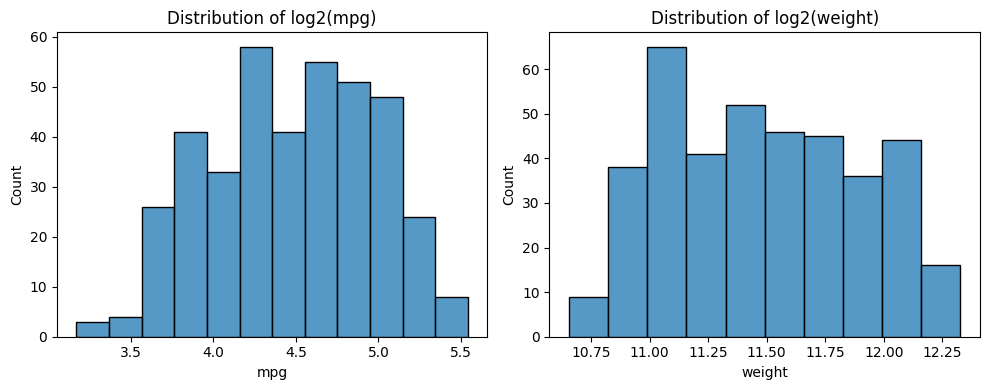

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(np.log2(df.mpg), ax=axes[0])
axes[0].set_title('Distribution of log2(mpg)')

sns.histplot(np.log2(df.weight), ax=axes[1])
axes[1].set_title('Distribution of log2(weight)')

plt.tight_layout()
plt.show()


After applying a log transformation, it appears that weight does not follow a log-normal distribution. However, the distribution of mpg seems to follow a log-normal pattern based on visual analysis.

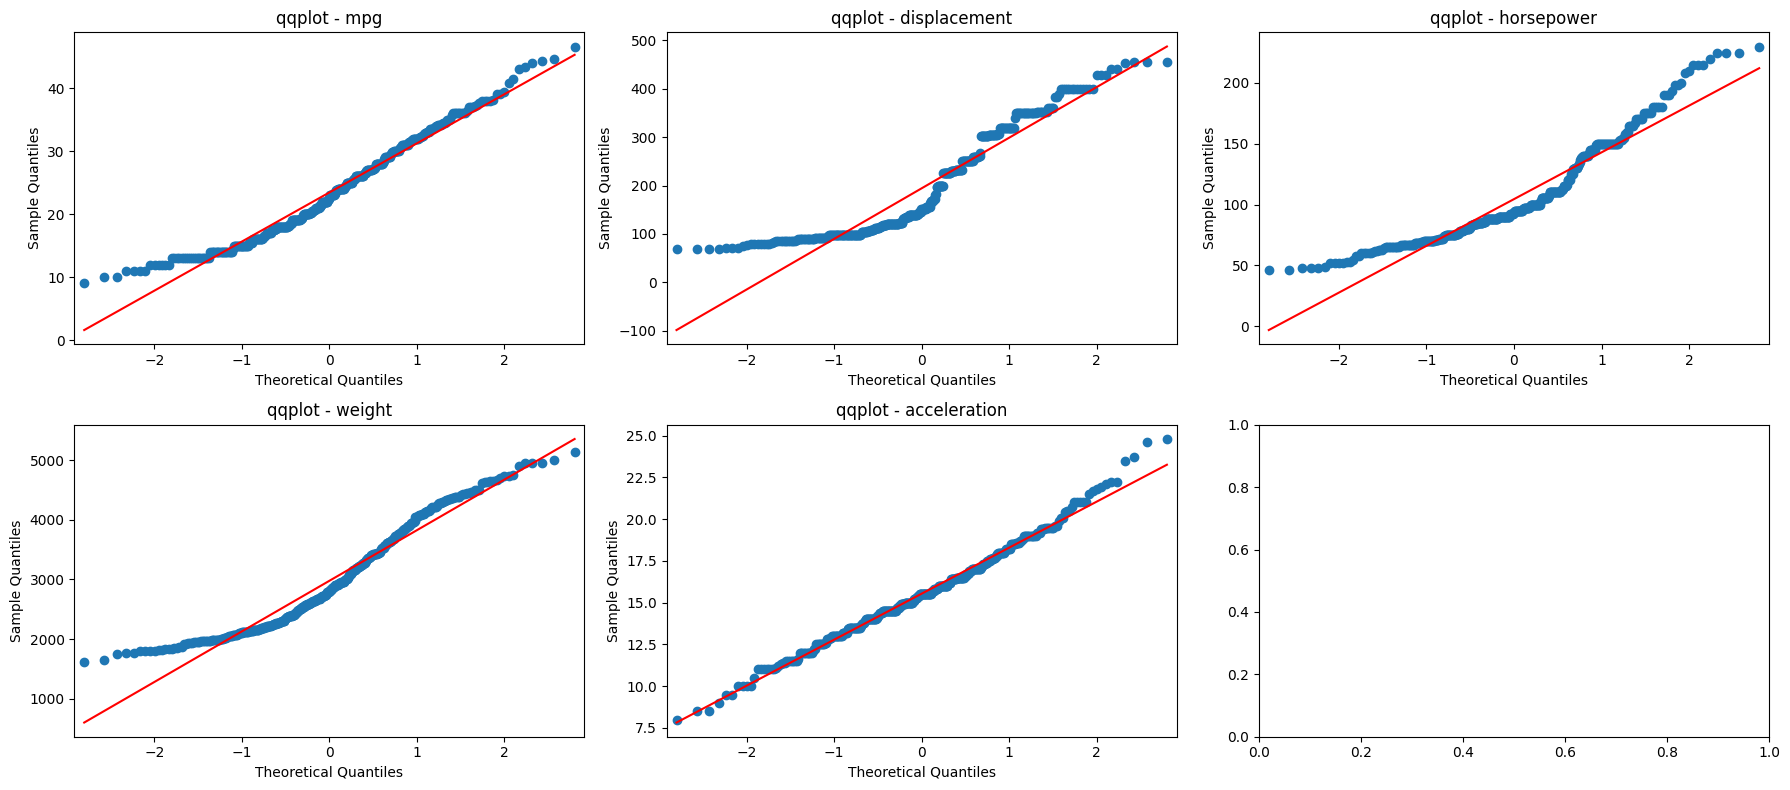

In [ ]:
# quantile-quantile plots on original data
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for i, num in enumerate(nums):
    qqplot(df[num], line='s', ax=axs[i//3][i%3])
    axs[i//3][i%3].set_title(f'qqplot - {num}')

plt.tight_layout()
plt.show()


The distribution of acceleration appears to be close to Gaussian based on both the histogram and QQ plot.

**Normality Tests**

The normality test can be divided into two parts:

**1. Visual Normality Checks:**

To visually check for normality, we can use the following:

mathematica

Histogram
Quantile-Quantile plot

**2. Statistical Normality Tests:**

There are various statistical tests for checking the normality of data, but the most common ones are:

rust

Shapiro-Wilk Test (applicable only for Gaussian distribution)
D’Agostino’s K² Test (applicable only for Gaussian distribution)
Anderson-Darling Test (applicable for many other distributions as well)

We will perform the Shapiro-Wilk test to check the normality of our numerical attributes.

    Null Hypothesis (H0): Data is drawn from a normal distribution.
    Significance Level (α): 0.05


In [ ]:
def shapiro_wilk_test(df: pd.DataFrame, cols: list, alpha=0.05):
    """
    Conduct the Shapiro-Wilk test for normality on the columns in `cols` of the dataframe `df` under significance level `alpha`.

    Args:
    df (pd.DataFrame): The dataframe to be analyzed
    cols (list): A list of column names to test for normality
    alpha (float): The significance level for the test

    Returns:
    None
    """
    for col in cols:
        _, p = st.shapiro(df[col])
        if p <= alpha:
            print(f'Rejected H0 under significance level {alpha}: {col} does not seem to be normally distributed')
        else:
            print(f'Fail to reject H0 due to lack of evidence under significance level {alpha}: {col} seems to be normally distributed')


In [ ]:
shapiro_wilk_test(df, nums)

Rejected H0 under significance level 0.05: mpg does not seem to be normally distributed
Rejected H0 under significance level 0.05: displacement does not seem to be normally distributed
Rejected H0 under significance level 0.05: horsepower does not seem to be normally distributed
Rejected H0 under significance level 0.05: weight does not seem to be normally distributed
Rejected H0 under significance level 0.05: acceleration does not seem to be normally distributed


We expected acceleration to have a normal distribution, but our test rejected this hypothesis. Let's examine the p-value.

The **stats.shapiro()** function tests for normality and returns two values: the test statistic and the p-value. Therefore, to properly assign values to the variables, we should modify the code as follows:

In [ ]:
test_stat, p_value = st.shapiro(df.acceleration)
p_value

0.030546151101589203

We rejected the null hypothesis under the significance level of 5%. However, if the significance level was set to 2.5%, we would have failed to reject the null hypothesis. We cannot change the p-value now, as it would be considered p-hacking. One possible reason for rejecting the null hypothesis could be that our data is not scaled. Scaling the data might improve our results.

We will now apply a power transform to make the data more Gaussian-like and check for normality on the transformed data.

**Power transform** is a family of parametric, monotonic transformations applied to data to make it more Gaussian-like. This transformation is useful for modeling issues related to heteroscedasticity (non-constant variance) or other situations where normality is desired.

In [ ]:
# import necessary library
from sklearn.preprocessing import PowerTransformer

# transform numerical features using PowerTransformer
pt = PowerTransformer()
df_tfnum = pd.DataFrame(pt.fit_transform(df[nums]), columns=nums)

# display first few rows of transformed data
df_tfnum.head()


,mpg,displacement,horsepower,weight,acceleration
0,-0.635451,1.119336,0.854984,0.744740,-1.317572
1,-1.142697,1.324530,1.443754,0.919500,-1.522941
2,-0.635451,1.175211,1.216062,0.678812,-1.732292
3,-0.965340,1.103648,1.216062,0.675864,-1.317572
4,-0.796543,1.093078,1.044925,0.691548,-1.945873


After applying power transforms to the data, several improvements were observed. Firstly, the data was scaled, resulting in it being centered at 0. Secondly, the distributions of the features became more Gaussian-like while preserving their original structures. This was achieved by applying transformations such as square-root, log, etc.

As a result of the power transforms, the acceleration feature remained Gaussian, the skewness was removed from the mpg and weight features, and the distribution of displacement became bimodal, which was consistent with the observations.

Interestingly, the distributions of mpg and weight after power transformation were similar to those obtained after applying a log transform. It is worth noting that the power transform function in scikit-learn indeed applies log transforms (refer to the documentation).


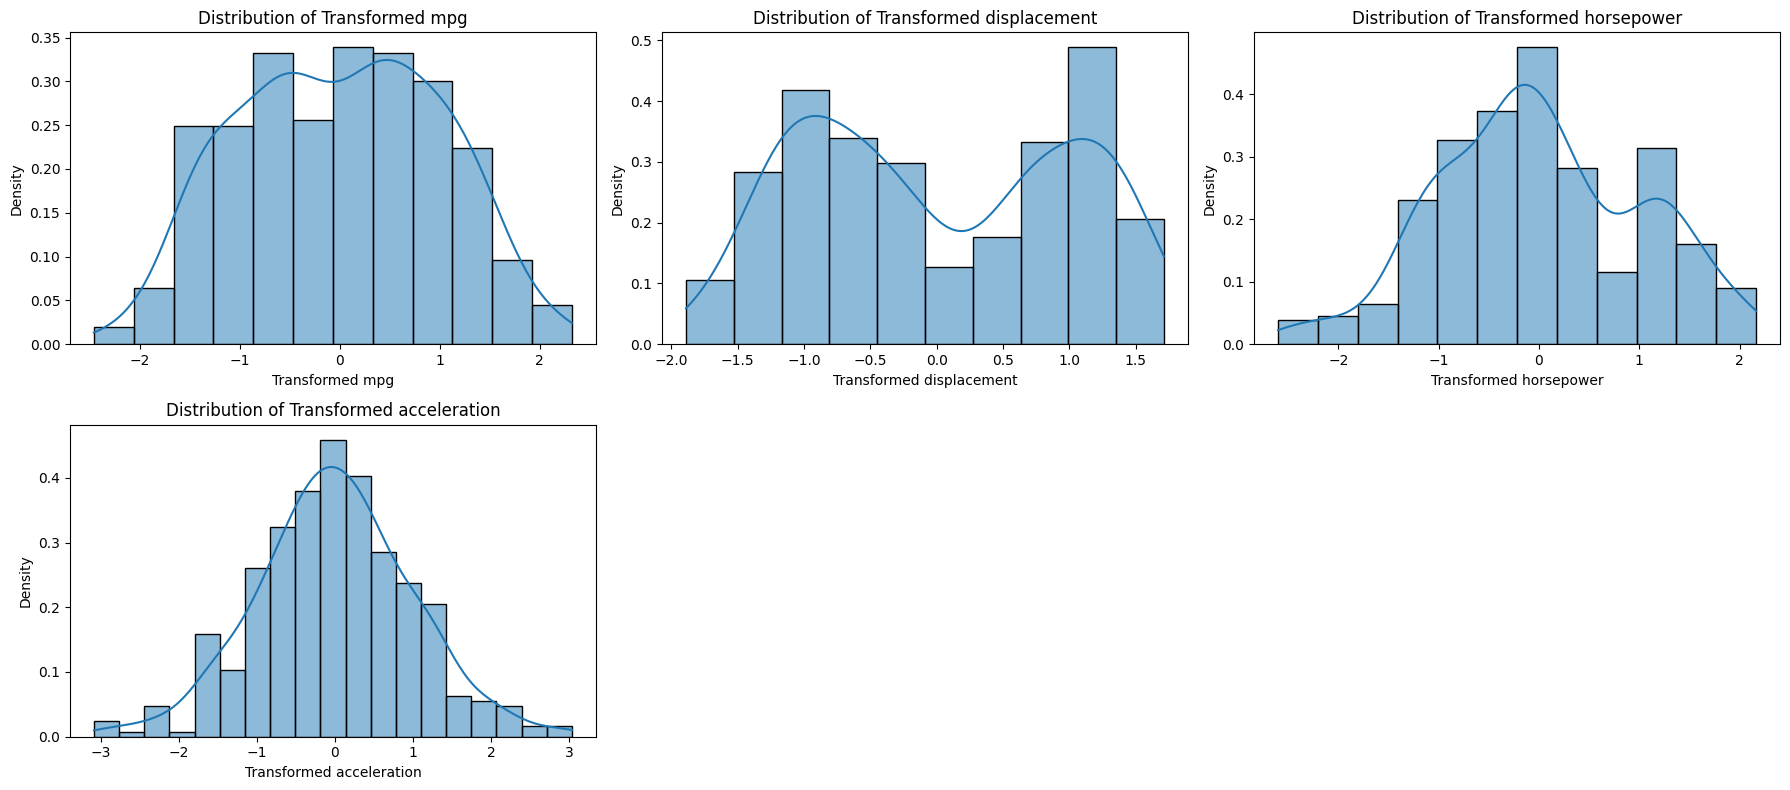

In [ ]:
# Create a figure with appropriate size
fig = plt.figure(figsize=(18, 8))

# Loop through each numeric feature and create a distribution plot
for i, num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(df_tfnum[num], kde=True, stat='density')
    ax.set_xlabel(f'Transformed {num}')
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of Transformed {num}')
    plt.tight_layout()


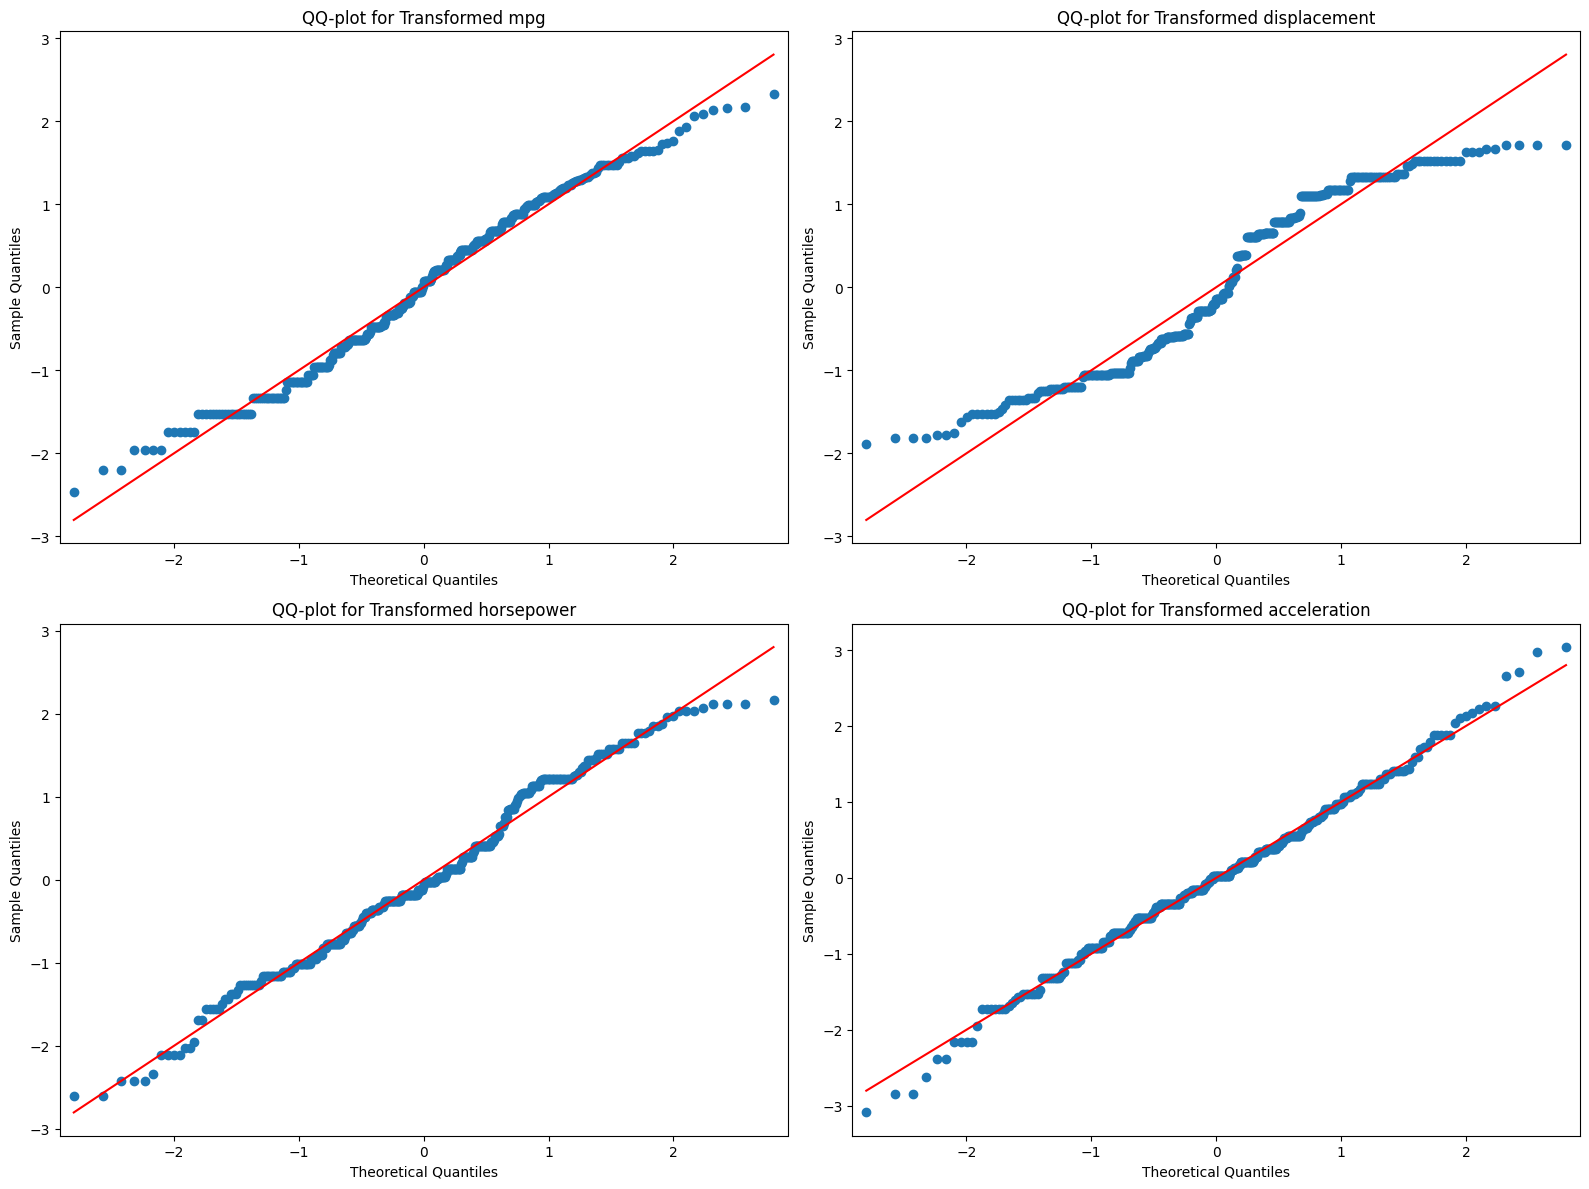

In [ ]:
#check for normality using quantile-quantile plots

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for i, num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
  qqplot(df_tfnum[num], line='s', ax=axs[i])
  axs[i].set_title(f'QQ-plot for Transformed {num}')

plt.tight_layout()

In [ ]:
#Use Shapiro-Wilk test to check for normality using Q-Q plots
shapiro_wilk_test(df_tfnum, ['mpg', 'displacement', 'horsepower', 'acceleration'])

Rejected H0 under significance level 0.05: mpg does not seem to be normally distributed
Rejected H0 under significance level 0.05: displacement does not seem to be normally distributed
Rejected H0 under significance level 0.05: horsepower does not seem to be normally distributed
Fail to reject H0 due to lack of evidence under significance level 0.05: acceleration seems to be normally distributed


The data shows that acceleration is normally distributed both visually and statistically after normalization.

In [ ]:
test_stat, p_value = st.shapiro(df_tfnum.acceleration)
p_value

0.3864997923374176

# **Section 3: Exploring correlation between two continuous variables**

**Spearman's Rank Correlation** is a non-parametric rank correlation method that measures the strength of a monotonic relationship between two variables. It calculates the correlation coefficient by converting the raw data into rank data and then using the formula:

$\large Corr_{_s}(x,y) = \frac{Cov(rank(x), rank(y))}{\sigma _{rank(x)}\sigma _{rank(y)}}$

The result is a value between -1 and 1, which is interpretable.

Spearman's Correlation is a common approach used in non-parametric statistics, as it doesn't assume any particular distribution of the data. It is also interpretable because the result falls in the range [-1, 1].

As a statistical hypothesis test, the method assumes that the samples are uncorrelated and fails to reject the null hypothesis H0 if the p-value is greater than the significance level.

For all correlation tests between mpg and other attributes, our null hypothesis will be that there is no correlation between mpg and the other attribute.

Null Hypothesis H0: There is no correlation between mpg and the other attribute.
Significance level (α) = 0.05.


In [ ]:
# Perform Spearman's rank correlation test between mpg and numerical features
for num in nums:
    if num == 'mpg':
        continue

    corr, p = st.spearmanr(df.mpg, df[num])

    print(f'\nCorrelation between `mpg` and `{num}`:\n')
    print(f'Correlation coefficient: {round(corr, 4)} \t p-value: {p}')

    if p <= ALPHA:
        print(f'Reject the null hypothesis at the significance level {ALPHA}: there is evidence of correlation between mpg and {num}.')
    else:
        print(f'Fail to reject the null hypothesis at the significance level {ALPHA}: there is no evidence of correlation between mpg and {num}.')



Correlation between `mpg` and `displacement`:

Correlation coefficient: -0.8552 	 p-value: 2.1957775993226176e-113
Reject the null hypothesis at the significance level 0.05: there is evidence of correlation between mpg and displacement.

Correlation between `mpg` and `horsepower`:

Correlation coefficient: -0.8536 	 p-value: 1.619383245501938e-112
Reject the null hypothesis at the significance level 0.05: there is evidence of correlation between mpg and horsepower.

Correlation between `mpg` and `weight`:

Correlation coefficient: -0.8756 	 p-value: 2.662377938025222e-125
Reject the null hypothesis at the significance level 0.05: there is evidence of correlation between mpg and weight.

Correlation between `mpg` and `acceleration`:

Correlation coefficient: 0.4415 	 p-value: 3.9036035663531793e-20
Reject the null hypothesis at the significance level 0.05: there is evidence of correlation between mpg and acceleration.


All null hypotheses (H0) are rejected at a significance level of 5%, indicating that there are statistically significant correlations between the variables. Except for acceleration, all other correlations are found to be very high, which is also evident from our previous plots.

In [ ]:
def calculate_correlation(x1, x2, method='spearman', alpha=0.05):
    """
    Calculate the correlation, p-value, and hypothesis test results between x1 and x2.

    :param x1: A pandas series or numpy array containing the first variable.
    :param x2: A pandas series or numpy array containing the second variable.
    :param method: The correlation method to use. Allowed values are 'pearson', 'spearman', and 'kendall'.
    :param alpha: The significance level to use for the hypothesis test.
    :return: A tuple containing the correlation coefficient, p-value, and hypothesis test result.
    """

    ALLOWED_METHODS = ['pearson', 'spearman', 'kendall']
    if method not in ALLOWED_METHODS:
        raise ValueError(f'Allowed methods are {ALLOWED_METHODS}.')

    if method == 'pearson':
        corr, p = st.pearsonr(x1, x2)
    elif method == 'spearman':
        corr, p = st.spearmanr(x1, x2)
    else:
        corr, p = st.kendalltau(x1, x2)

    h0 = 'rejected' if p <= alpha else 'failed to reject'

    return corr, p, h0


In [ ]:
# Create an empty DataFrame to store correlation information
df_corr = pd.DataFrame(columns=['Attribute 1', 'Attribute 2', 'Correlation', 'p-value', 'Null Hypothesis'])

# Loop through each pair of numeric attributes and test for correlation
for pair in itertools.combinations(nums, 2):

    # Calculate correlation, p-value, and null hypothesis using the test_correlation function
    corr, p, h0 = calculate_correlation(df[pair[0]], df[pair[1]])

    # Add the results to the DataFrame
    df_corr = df_corr.append({'Attribute 1': pair[0], 'Attribute 2': pair[1],
                              'Correlation': round(corr, 5), 'p-value': p, 'Null Hypothesis': h0}, ignore_index=True)

# Display the resulting DataFrame
df_corr


<ipython-input-66-2642d038ff87>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Attribute 1': pair[0], 'Attribute 2': pair[1],
<ipython-input-66-2642d038ff87>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Attribute 1': pair[0], 'Attribute 2': pair[1],
<ipython-input-66-2642d038ff87>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Attribute 1': pair[0], 'Attribute 2': pair[1],
<ipython-input-66-2642d038ff87>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append({'Attribute 1': pair[0], 'Attribute 2': pair[1],
<ipython-input-66-26

,Attribute 1,Attribute 2,Correlation,p-value,Null Hypothesis
0,mpg,displacement,-0.85523,2.195778e-113,rejected
1,mpg,horsepower,-0.85362,1.619383e-112,rejected
2,mpg,weight,-0.87559,2.662378e-125,rejected
3,mpg,acceleration,0.44154,3.903604e-20,rejected
4,displacement,horsepower,0.87617,1.126737e-125,rejected
5,displacement,weight,0.94563,2.463170e-192,rejected
6,displacement,acceleration,-0.49940,4.061210e-26,rejected
7,horsepower,weight,0.87882,2.182674e-127,rejected
8,horsepower,acceleration,-0.65814,5.157840e-50,rejected
9,weight,acceleration,-0.40511,6.484246e-17,rejected


Some pairs, such as (mpg, acceleration), (displacement, acceleration), and (weight, acceleration), display moderate correlation, while the remaining pairs demonstrate high correlation.

# **Section 4. Statistical Significance Tests**

We will now conduct significance tests to determine if two samples have the same mean or not. There are two types of significance tests available for different conditions.

**Parametric Statistical Significance Tests**

    The Student’s t-test is a parametric test that is used to determine whether the means of two independent normal distributed samples are statistically different from each other.

    The Analysis of Variance Test (ANOVA) is also a parametric test that is used to determine whether the means of two or more independent normal distributed samples are statistically different from each other.

ANOVA is useful when comparing more than two groups, as it can determine whether any of the groups are statistically different from each other. However, it does not quantify which groups differ or by how much.

Alternatively, t-tests can be applied pairwise to compare two groups at a time.

**Non-Parametric and Parametric Statistical Significance Tests**

    Mann-Whitney U Test - Non-parametric equivalent of Student's t-test.
    Kruskal-Wallis H Test - Non-parametric equivalent of ANOVA for median comparison.
    t-Test - Parametric test for comparing means of two independent samples assuming normality.
    ANOVA - Parametric test for comparing means of more than two independent samples assuming normality.

We will apply the appropriate test depending on the sample distribution. If the sample is normally distributed, we will use parametric tests, otherwise, non-parametric tests will be used.

Let's examine if there is a significant difference between the mean acceleration of cars in **japan** and **usa**.
First, we will check the normality assumption of the acceleration variable in both japan and usa. Then we will select the appropriate statistical test based on the results of our normality test.

In [ ]:
shapiro_wilk_test(df[df.origin == 'japan'], ['acceleration'])

Fail to reject H0 due to lack of evidence under significance level 0.05: acceleration seems to be normally distributed


In [ ]:
shapiro_wilk_test(df[df.origin=='usa'], ['acceleration'])

Fail to reject H0 due to lack of evidence under significance level 0.05: acceleration seems to be normally distributed


Since both the samples of acceleration for Japan and USA follow a normal distribution, we can perform a **parametric test** to compare their means.

We set up our null hypothesis as:

H0: The sample mean of acceleration for Japan is equal to the sample mean of acceleration for USA.

We choose the significance level as α=0.05.

In [ ]:
# because the variance is not same for the two distributions hence equal_var=False
_, p = st.ttest_ind(df[df.origin=='japan'].acceleration, df[df.origin=='usa'].acceleration, equal_var=False)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')



Rejected H0 under 5.0% significance, Different distributions.


In [ ]:
# Set significance level
ALPHA = 0.05

# Perform one-way ANOVA test
_, p = st.f_oneway(df[df.origin=='japan'].acceleration, df[df.origin=='usa'].acceleration, df[df.origin=='europe'].acceleration)

# Determine if null hypothesis is rejected or failed to reject
if p <= ALPHA:
    print(f'At a {ALPHA*100}% significance level, we reject the null hypothesis and conclude that the distributions of acceleration for the different origins are different.')
else:
    print(f'At a {ALPHA*100}% significance level, we fail to reject the null hypothesis and conclude that there is not enough evidence to suggest that the distributions of acceleration for the different origins are different.')


At a 5.0% significance level, we reject the null hypothesis and conclude that the distributions of acceleration for the different origins are different.


Let's test whether the **distribution of horsepower** is the same across all regions.

In [ ]:
shapiro_wilk_test(df[df.origin=='japan'], ['horsepower'])

Rejected H0 under significance level 0.05: horsepower does not seem to be normally distributed


In [ ]:
shapiro_wilk_test(df[df.origin=='europe'], ['horsepower'])

Rejected H0 under significance level 0.05: horsepower does not seem to be normally distributed


In [ ]:
shapiro_wilk_test(df[df.origin=='usa'], ['horsepower'])

Rejected H0 under significance level 0.05: horsepower does not seem to be normally distributed


As the distribution of horsepower across different regions is not normal, we will apply a **non-parametric test**. Our null hypothesis (H0) is that the sample distributions of horsepower across regions are equal, with a significance level (α) of 0.05.

In [ ]:
# Set the significance level
ALPHA = 0.05

# Perform Kruskal-Wallis test
japan_hp = df.loc[df.origin == 'japan', 'horsepower']
usa_hp = df.loc[df.origin == 'usa', 'horsepower']
europe_hp = df.loc[df.origin == 'europe', 'horsepower']

stat, p = st.kruskal(japan_hp, usa_hp, europe_hp)

# Check if the null hypothesis is rejected
if p <= ALPHA:
    print(f"The null hypothesis is rejected at {ALPHA*100}% significance level. The distributions of horsepower are significantly different among the three origins.")
else:
    print(f"The null hypothesis cannot be rejected at {ALPHA*100}% significance level. The distributions of horsepower are not significantly different among the three origins.")


The null hypothesis is rejected at 5.0% significance level. The distributions of horsepower are significantly different among the three origins.


Compare the **distribution of acceleration** between samples with mpg_level high and medium.

In [ ]:
# Set the significance level
ALPHA = 0.05

# Perform Mann-Whitney U test
statistic, p = st.mannwhitneyu(df[df.mpg_level == 'high'].acceleration,
                                   df[df.mpg_level == 'medium'].acceleration)

# Check if p-value is less than or equal to the significance level
if p <= ALPHA:
    print(f'Reject the null hypothesis at {ALPHA*100}% significance level. The two distributions are different.')
else:
    print(f'Fail to reject the null hypothesis at {ALPHA*100}% significance level. The two distributions are the same.')


Fail to reject the null hypothesis at 5.0% significance level. The two distributions are the same.


Analyzing the **distribution of mpg** across different years.

In [ ]:
# Group the mpg data by model year
acc_gb_year = df.groupby('model_year')['mpg']

# Create a list of mpg values for each model year
acc_yr = [list(acc_gb_year.get_group(yr)) for yr in df.model_year.unique()]

# Perform the Kruskal-Wallis test and check for significance
_, p = st.kruskal(*acc_yr)

# Define significance level
ALPHA = 0.05

# Check the p-value and print the result
if p <= ALPHA:
    print(f"Reject the null hypothesis at {ALPHA*100}% significance level. The distributions are different.")
else:
    print(f"Fail to reject the null hypothesis at {ALPHA*100}% significance level. The distributions are the same.")


Reject the null hypothesis at 5.0% significance level. The distributions are different.


# **Section 5: Relation between Categorical and Continous attributes**

ANOVA (Analysis of Variance) is a statistical test used to determine whether two or more population means are equal or not by analyzing the differences among the means of the samples. It is used when we want to compare the means of more than two groups at the same time. The test calculates the F-ratio by comparing the between-group variance to the within-group variance.

The hypothesis of the ANOVA test is as follows:

    Null Hypothesis (H0): The means of all groups are equal.
    Alternative Hypothesis (H1): At least one group mean is different from the others.

The test uses the F-statistic, which is calculated by dividing the between-group variance by the within-group variance. A large F-value means that the between-group variance is much greater than the within-group variance, indicating that there is a significant difference between the means of the groups.

The ANOVA test assumes that the samples are independent, normal, and have equal variances. If the ANOVA test rejects the null hypothesis, we need to perform a post-hoc test to determine which groups are significantly different from each other.

In the context of machine learning, the ANOVA test can be used for feature selection, where we can determine which features are relevant for predicting the target variable. By performing ANOVA on each feature, we can calculate the F-value and p-value and select the features with a low p-value, indicating a significant relationship with the target variable.

In [ ]:
# Perform ANOVA test between cylinders and other continuous attributes
result_f = feature_selection.f_classif(df.loc[:, 'mpg': 'acceleration'], df.cylinders)

# Create a DataFrame to store ANOVA test results
anova_test_cat = pd.DataFrame({
    'cat_attribute': 'cylinders',
    'cont_attribute': df.loc[:, 'mpg': 'acceleration'].columns,
    'f_value': result_f[0],
    'p_value': result_f[1],
    'alpha': ALPHA
})

# Determine if null hypothesis is rejected or not
anova_test_cat['null_hypothesis'] = np.where(anova_test_cat.p_value <= ALPHA, 'rejected', 'not rejected')

# Classify the relationship between the attributes
anova_test_cat['relationship'] = np.where(anova_test_cat.null_hypothesis == 'rejected', 'dependent', 'independent')

anova_test_cat


,cat_attribute,cont_attribute,f_value,p_value,alpha,null_hypothesis,relationship
0,cylinders,mpg,172.954629,8.785541e-85,0.05,rejected,dependent
1,cylinders,displacement,933.260216,3.054493e-197,0.05,rejected,dependent
2,cylinders,horsepower,297.855648,1.079822e-116,0.05,rejected,dependent
3,cylinders,weight,414.851887,1.751845e-138,0.05,rejected,dependent
4,cylinders,acceleration,48.677596,3.709542e-33,0.05,rejected,dependent


In [ ]:
# Perform ANOVA test on selected categorical features with respect to mpg
from sklearn.feature_selection import f_classif

cat_features = ['origin', 'cylinders', 'model_year']
result_f, result_p = f_classif(df_cat_label[cat_features], df.mpg)

ALPHA = 0.05
anova_test_cat = pd.DataFrame({
    'cont-attr': 'mpg',
    'cat-attr': cat_features,
    'f': result_f,
    'p': result_p,
    'alpha': ALPHA
})

anova_test_cat['H0'] = np.where(anova_test_cat['p'] <= ALPHA, 'rejected', 'fail to reject')
anova_test_cat['relation'] = np.where(anova_test_cat['H0'] == 'rejected', 'dependent', 'independent')
anova_test_cat

,cont-attr,cat-attr,f,p,alpha,H0,relation
0,mpg,origin,2.345244,3.516516e-09,0.05,rejected,dependent
1,mpg,cylinders,12.104269,2.855307e-63,0.05,rejected,dependent
2,mpg,model_year,3.795294,3.748099e-20,0.05,rejected,dependent
